# Optimization towards a Perfect Entangler

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from IPython.display import display
import weylchamber as wc
from weylchamber.visualize import WeylChamber
from weylchamber.coordinates import from_magic

%watermark -v --iversions

numpy            1.16.2
matplotlib       3.0.3
scipy            1.2.1
qutip            4.3.1
weylchamber      0.3.1
krotov           0.3.0+dev
matplotlib.pylab 1.16.2
CPython 3.6.8
IPython 7.4.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example demonstrates the optimization with an "unconventional"
optimization target. Instead of a state-to-state transition, or the realization
of a specific quantum gate, we optimize for an arbitrary perfectly entangling
gate. See

* P. Watts, et al., Phys. Rev. A 91, 062306 (2015)

* M. H. Goerz, et al., Phys. Rev. A 91, 062307 (2015)

for details.

## Hamiltonian

We consider a generic two-qubit Hamiltonian (motivated from the example of two
superconducting transmon qubits, truncated to the logical subspace),

$$
\begin{equation}
  \op{H}(t)
    = - \frac{\omega_1}{2} \op{\sigma}_{z}^{(1)}
      - \frac{\omega_2}{2} \op{\sigma}_{z}^{(2)}
      + 2 J \left(
            \op{\sigma}_{x}^{(1)} \op{\sigma}_{x}^{(2)}
            + \op{\sigma}_{y}^{(1)} \op{\sigma}_{y}^{(2)}
        \right)
      + u(t) \left(
            \op{\sigma}_{x}^{(1)} + \lambda \op{\sigma}_{x}^{(2)}
        \right),
\end{equation}
$$

where $\omega_1$ and $\omega_2$ are the energy level splitting of the
respective qubit, $J$ is the effective coupling strength and $u(t)$ is the
control field. $\lambda$ defines the strength of the qubit-control coupling for
qubit 2, relative to qubit 1.

We use the following parameters:

In [2]:
w1 = 1.1  # qubit 1 level splitting
w2 = 2.1  # qubit 2 level splitting
J = 0.2  # effective qubit coupling
u0 = 0.3  # initial driving strength
la = 1.1  # relative pulse coupling strength of second qubit
T = 25.0  # final time
nt = 250  # number of time steps

tlist = np.linspace(0, T, nt)

These are for illustrative purposes only, and do not correspond to any
particular physical system.

The initial guess is defined as




In [3]:
def eps0(t, args):
    return u0 * krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=(T / 20), t_fall=(T / 20), func='sinsq'
    )

In [4]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

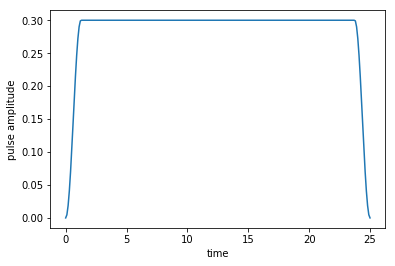

In [5]:
plot_pulse(eps0, tlist)

We instantiate the Hamiltonian with this guess pulse

In [6]:
def hamiltonian(w1=w1, w2=w2, J=J, la=la, u0=u0):
    """Two qubit Hamiltonian

    Args:
        w1 (float): energy separation of the first qubit levels
        w2 (float): energy separation of the second qubit levels
        J (float): effective coupling between both qubits
        la (float): factor that pulse coupling strength differs for second qubit
        u0 (float): constant amplitude of the driving field
    """
    # local qubit Hamiltonians
    Hq1 = 0.5 * w1 * np.diag([-1, 1])
    Hq2 = 0.5 * w2 * np.diag([-1, 1])

    # lift Hamiltonians to joint system operators
    H0 = np.kron(Hq1, np.identity(2)) + np.kron(np.identity(2), Hq2)

    # define the interaction Hamiltonian
    sig_x = np.array([[0, 1], [1, 0]])
    sig_y = np.array([[0, -1j], [1j, 0]])
    Hint = 2 * J * (np.kron(sig_x, sig_x) + np.kron(sig_y, sig_y))
    H0 = H0 + Hint

    # define the drive Hamiltonian
    H1 = np.kron(np.array([[0, 1], [1, 0]]), np.identity(2)) + la * np.kron(
        np.identity(2), np.array([[0, 1], [1, 0]])
    )

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0)
    H1 = qutip.Qobj(H1)

    return [H0, [H1, eps0]]


H = hamiltonian(w1=w1, w2=w2, J=J, la=la, u0=u0)

As well as the canonical two-qubit logical basis,

In [7]:
psi_00 = qutip.Qobj(np.kron(np.array([1, 0]), np.array([1, 0])))
psi_01 = qutip.Qobj(np.kron(np.array([1, 0]), np.array([0, 1])))
psi_10 = qutip.Qobj(np.kron(np.array([0, 1]), np.array([1, 0])))
psi_11 = qutip.Qobj(np.kron(np.array([0, 1]), np.array([0, 1])))

with the corresponding projectors to calculate population dynamics below.

In [8]:
proj_00 = qutip.ket2dm(psi_00)
proj_01 = qutip.ket2dm(psi_01)
proj_10 = qutip.ket2dm(psi_10)
proj_11 = qutip.ket2dm(psi_11)

## Objectives for a perfect entangler

Our optimization target is the closest perfectly entangling gate, quantified by
the perfect-entangler functional

$$
\begin{equation}
  F_{PE} = g_3 \sqrt{g_1^2 + g_2^2} - g_1,
\end{equation}
$$

where $g_1, g_2, g_3$ are the local invariants of the implemented gate that
uniquely identify its non-local content. The local invariants are closely
related to the Weyl coordinates $c_1, c_2, c_3$, which provide a useful
geometric visualization in the Weyl chamber. The perfectly entangling gates lie
within a polyhedron in the Weyl chamber and $F_{PE}$ becomes zero at its
boundaries. We define $F_{PE} \equiv 0$ for *all* perfect entanglers (inside
the polyhedron)

A list of four objectives that encode the minimization of $F_{PE}$ are
generated by calling the `gate_objectives` function with the canonical basis,
and `"PE"` as target "gate".

In [9]:
objectives = krotov.gate_objectives(
    basis_states=[psi_00, psi_01, psi_10, psi_11], gate="PE", H=H
)

In [10]:
objectives

[Objective[|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'],
 Objective[|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'],
 Objective[|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'],
 Objective[|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE']]

The initial states in these objectives are not the canonical basis states, but a Bell
basis,

In [11]:
# NBVAL_IGNORE_OUTPUT
for obj in objectives:
    display(obj.initial_state)

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.+0.j        ]
 [0.+0.70710678j]
 [0.+0.70710678j]
 [0.+0.j        ]]

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.70710678]
 [-0.70710678]
 [ 0.        ]]

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[0.+0.70710678j]
 [0.+0.j        ]
 [0.+0.j        ]
 [0.-0.70710678j]]

Since we don't know *which* perfect entangler the optimization result will
implement, we cannot associate any "target state" with each objective, and the
`target` attribute is set to the string 'PE'.

We can treat the above objectives as a "black box"; the only important
consideration is that the `chi_constructor` that we will pass to
`optimize_pulses` to calculating the boundary condition for the backwards
propagation,

$$
\begin{equation}
  \ket{\chi_{k}} = \frac{\partial F_{PE}}{\partial \bra{\phi_k}} \Bigg|_{\ket{\phi_{k}(T)}}\,,
\end{equation}
$$

must be consistent with how the `objectives` are set up. For the perfect
entanglers functional, the calculation of the $\ket{\chi_{k}}$ is relatively
complicated. The `weylchamber` package
(https://github.com/qucontrol/weylchamber) contains a suitable routine that
works on the `objectives` exactly as defined above (specifically, under the
assumption that the $\ket{\phi_k}$ are the appropriate Bell states):

In [12]:
help(wc.perfect_entanglers.make_PE_krotov_chi_constructor)

Help on function make_PE_krotov_chi_constructor in module weylchamber.perfect_entanglers:

make_PE_krotov_chi_constructor(canonical_basis, unitarity_weight=0)
    Return a constructor for the χ's in a PE optimization.
    
    Return a `chi_constructor` that determines the boundary condition of the
    backwards propagation in an optimization towards a perfect entangler in
    Krotov's method, based on the foward-propagtion of the Bell states. In
    detail, the function returns a callable function that calculates
    
    .. math::
    
        \ket{\chi_{i}}
        =
        \frac{\partial F_{PE}}{\partial \bra{\phi_i}}
        \Bigg|_{\ket{\phi_{i}(T)}}
    
    for all $i$ with $\ket{\phi_{0}(T)}, ..., \ket{\phi_{3}(T)}$ the forward
    propagated Bell states at final time $T$, cf. Eq. (33b) in Ref. [1].
    $F_{PE}$ is the perfect-entangler functional
    :func:`~weylchamber.perfect_entanglers.F_PE`. For the details of the
    derivative see Appendix G in Ref. [2].
    
    Refer

In [13]:
chi_constructor = wc.perfect_entanglers.make_PE_krotov_chi_constructor(
    [psi_00, psi_01, psi_10, psi_11]
)

Again, the key point to take from this is that when defining a new or unusual
functional, **the `chi_constructor` must be congruent with the way the
objectives are defined**. As a user, you can choose whatever definition of
objectives and implementation of `chi_constructor` is most suitable, as long
they are compatible.

## Second Order Update Equation

As the perfect-entangler functional $F_{PE}$ is non-linear in
the states, Krotov's method requires the second-order contribution in
order to guarantee monotonic convergence (see D. M. Reich, et al., J. Chem.
Phys. 136, 104103 (2012) for details). The second order update equation
reads

$$
\begin{split}
  \epsilon^{(i+1)}(t)
  & =
  \epsilon^{ref}(t) + \frac{S(t)}{\lambda_a} \Im \left\{
    \sum_{k=1}^{N}
    \Bigg\langle
      \chi_k^{(i)}(t)
    \Bigg\vert
    \left.\frac{\partial \Op{H}}{\partial \epsilon}\right\vert_{{\scriptsize \begin{matrix}\phi^{(i+1)}(t) \\\epsilon^{(i+1)}(t)\end{matrix}}}
    \Bigg\vert
    \phi_k^{(i+1)}(t)
    \Bigg\rangle
    \\
    +
    \frac{1}{2} \sigma(t)
    \Bigg\langle
      \Delta\phi_k(t)
      \Bigg\vert
              \left.\frac{\partial \Op{H}}{\partial \epsilon}\right\vert_{{\scriptsize \begin{matrix}\phi^{(i+1)}(t)\\\epsilon^{(i+1)}(t)\end{matrix}}}
      \Bigg\vert
      \phi_k^{(i+1)}(t)
     \Bigg\rangle
  \right\}\,,
\end{split}
$$

where the term proportional to $\sigma(t)$ defines the second-order
contribution. In order to use the second-order term, we need to pass
a function to evaluate this $\sigma(t)$ as `sigma` to `optimize_pulses`. We use
the equation

$$
\begin{equation}
   \sigma(t) = -\max\left(\varepsilon_A,2A+\varepsilon_A\right)
\end{equation}
$$

with $\varepsilon_A$ a small non-negative number, and $A$ a parameter that can
be recalculated numerically after each iteration (see D. M. Reich, et al., J.
Chem. Phys. 136, 104103 (2012) for details).

Generally, $\sigma(t)$ has parametric dependencies like $A$ in this example,
which should be refreshed for each iteration. Thus, since `sigma` holds
internal state, it must be implemented as an object subclassing from
`krotov.second_order.Sigma`:


In [14]:
class sigma(krotov.second_order.Sigma):
    def __init__(self, A, epsA=0):
        self.A = A
        self.epsA = epsA

    def __call__(self, t):
        ϵ, A = self.epsA, self.A
        return -max(ϵ, 2 * A + ϵ)

    def refresh(
        self,
        forward_states,
        forward_states0,
        chi_states,
        chi_norms,
        optimized_pulses,
        guess_pulses,
        objectives,
        result,
    ):
        try:
            Delta_J_T = result.info_vals[-1][0] - result.info_vals[-2][0]
        except IndexError:  # first iteration
            Delta_J_T = 0
        self.A = krotov.second_order.numerical_estimate_A(
            forward_states, forward_states0, chi_states, chi_norms, Delta_J_T
        )

This combines the evaluation of the function, `sigma(t)`, with the recalculation of
$A$ (or whatever parametrizations another $\sigma(t)$ function might contain)
in `sigma.refresh`, which `optimize_pulses` invokes automatically at the
end of each iteration.

## Optimization

Before running the optimization, we define the shape function $S(t)$ to
maintain the smooth switch-on and switch-off, and the $\lambda_a$ parameter
that determines the overall magnitude of the pulse update in each iteration:




In [15]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=T / 20, t_fall=T / 20, func='sinsq'
    )

pulse_options = {H[1][1]: dict(lambda_a=1.0e2, shape=S)}

In previous examples, we have used `info_hook` routines that display and store
the value of the functional $J_T$. Here, we will also want to analyze the
optimization in terms of the Weyl chamber coordinates $(c_1, c_2, c_3)$. We
therefore write a custom `print_fidelity` routine that prints $F_{PE}$ as well
as the gate concurrence (as an alternative measure for the entangling power of
quantum gates), and results in the storage of a nested tuple `(F_PE, (c1, c2,
c3))` for each iteration, in `Result.info_vals`.


In [16]:
def print_fidelity(**args):
    basis = [objectives[i].initial_state for i in [0, 1, 2, 3]]
    states = [args['fw_states_T'][i] for i in [0, 1, 2, 3]]
    U = wc.gates.gate(basis, states)
    c1, c2, c3 = wc.coordinates.c1c2c3(from_magic(U))
    g1, g2, g3 = wc.local_invariants.g1g2g3_from_c1c2c3(c1, c2, c3)
    conc = wc.perfect_entanglers.concurrence(c1, c2, c3)
    F_PE = wc.perfect_entanglers.F_PE(g1, g2, g3)
    print("    F_PE: %f\n    gate conc.: %f" % (F_PE, conc))
    return F_PE, [c1, c2, c3]

This structure must be taken into account in a `check_convergence` routine. This would
affect routines like `krotov.convergence.value_below` that assume that
`Result.info_vals` contains the values of $J_T$ only. Here, we define a check
that stops the optimization as soon as we reach a perfect entangler:

In [17]:
def check_PE(result):
    # extract F_PE from (F_PE, [c1, c2, c3])
    F_PE = result.info_vals[-1][0]
    if F_PE <= 0:
        return "achieved perfect entangler"
    else:
        return None

In [18]:
oct_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chi_constructor,
    info_hook=krotov.info_hooks.chain(
        krotov.info_hooks.print_debug_information, print_fidelity
    ),
    check_convergence=check_PE,
    sigma=sigma(A=0.0),
    iter_stop=20,
)

Iteration 0
    objectives:
        1:|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        2:|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        3:|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        4:|(4)⟩ - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
    adjoint objectives:
        1:⟨(4)| - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        2:⟨(4)| - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        3:⟨(4)| - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
        4:⟨(4)| - {[Herm[4,4], [Herm[4,4], u1(t)]]} - 'PE'
    S(t) (ranges): [0.000000, 1.000000]
    duration: 1.3 secs (started at 2019-04-11 13:15:10)
    optimized pulses (ranges): [0.00, 0.30]
    ∫gₐ(t)dt: 0.00e+00
    λₐ: 1.00e+02
    storage (bw, fw, fw0): None, [4 * ndarray(250)] (0.5 MB), [4 * ndarray(250)] (0.5 MB)
    fw_states_T norm: 1.000000, 1.000000, 1.000000, 1.000000
    F_PE: 1.447666
    gate conc.: 0.479571
Iteration 1
    duration: 4.5 secs (started at 2019-04-11 13:15:11)
    optimized pulses (ranges): [0

In [19]:
oct_result

Krotov Optimization Result
--------------------------
- Started at 2019-04-11 13:15:10
- Number of objectives: 4
- Number of iterations: 9
- Reason for termination: Reached convergence: achieved perfect entangler
- Ended at 2019-04-11 13:15:52

We can visualize how each iteration of the optimization brings the dynamics
closer to the polyhedron of perfect entanglers (using the Weyl chamber
coordinates that we calculated in the `info_hook` routine `print_fidelity`, and
that were stored in `Result.info_vals`).

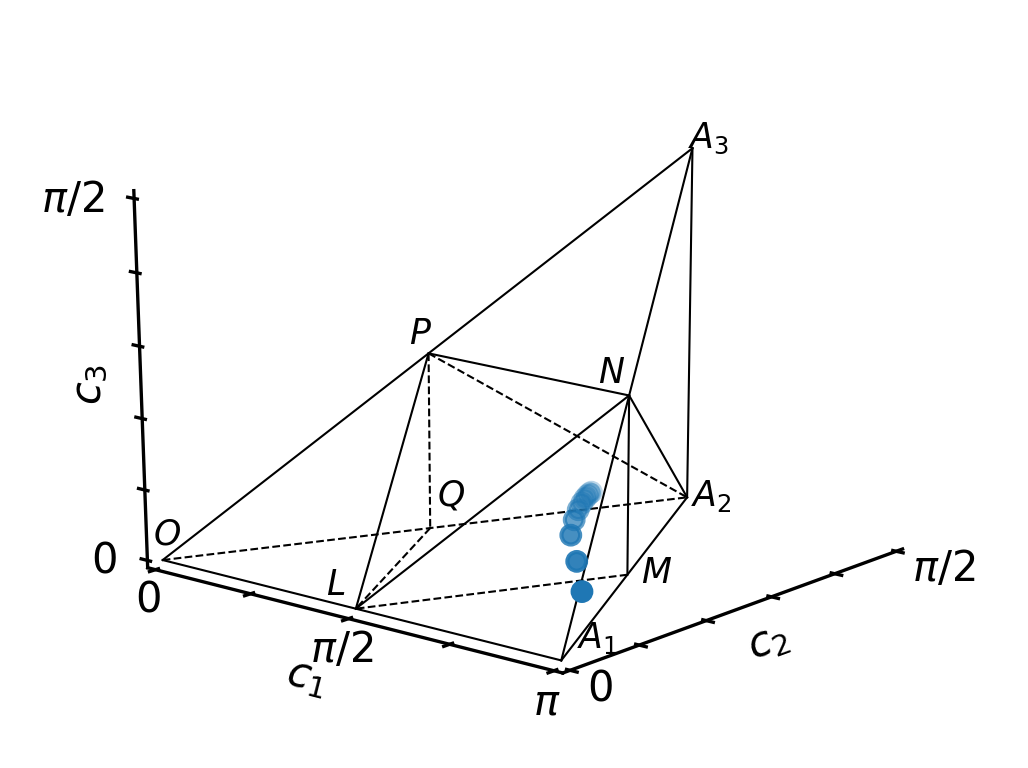

In [20]:
w = WeylChamber()
c1c2c3 = [oct_result.info_vals[i][1] for i in range(len(oct_result.iters))]
for i in range(len(oct_result.iters)):
    w.add_point(c1c2c3[i][0], c1c2c3[i][1], c1c2c3[i][2])
w.plot()

The final optimized control field looks like this:

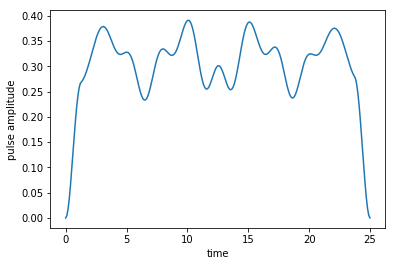

In [21]:
plot_pulse(oct_result.optimized_controls[0], tlist)